In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random




In [239]:
class vehicle():
    # we gonna use the general car following model
    # The basic relationship between a leader
    # and a follower vehicle is in this case a stimulus-response type of function. The
    # GHR model states that the follower’s acceleration is proportional to the speed of
    # the follower, the speed difference between follower and leader, and the space
    # headway, (Brackstone and McDonald, 1998). That is, the acceleration of the
    # follower at time t is calculated as 
    # a_n(t) = alpha * v_n^beta(t) * (v_n-1(t - T) - v_n(t - T)) / (x_n-1(t - T) - x_n(t - T))^gamma
    # alpha > 0
    # reaction time T > 0, use https://doi.org/10.1016/j.aap.2007.08.012

    def __init__(self, x, v, a, L,reaction_time, global_ts, delta_t):
        self.current_x = x # location on the time-space graph (meter), head of the vehicle
        self.current_v = v # velocity (m/s)
        self.current_a = a # acceleration (m/s^2)
        self.delta_t = delta_t
        self.L= L # length of the vehicle
        self.alpha = 0.9
        self.beta = 0
        self.gamma = 0
        self.T = reaction_time # reaction time
        
        self.history_t = [global_ts]
        self.history_x = [self.current_x]
        self.history_v = [self.current_v]
        self.history_a = [self.current_a]

    def update(self, a, ts):
        self.current_a = a
        self.current_v = self.current_v + self.current_a * self.delta_t
        self.current_x = self.current_x + self.current_v * self.delta_t
        self.history_a.append(self.current_a)
        self.history_x.append(self.current_x)
        self.history_v.append(self.current_v)
        self.history_t.append(ts)


In [252]:
num_vehicles = 10
global_clock = 0 # sec
green_light = 30 # sec
red_light = 30 # sec
delta_t = 0.1 # sec
mean_space_clearance = 5 # meters
mean_speed = 17.8 # m/s = 40 mph
mean_vehicle_length = 4.5 # meters
mean_reaction_time = 1 # sec
# from 0 sec is red light, 30 sec is green light
lane_length = 200 # meters, say 300 meters is the stop bar before the intersection

leading_vehilce = vehicle(0, mean_speed, 0, mean_vehicle_length, mean_reaction_time,global_clock,delta_t)
vehicle_list =  [leading_vehilce]

accumulation_x = 0
for _ in range(num_vehicles):
    following_clearance = np.random.exponential(mean_space_clearance, 1)[0]
    init_speed = 17.8 + np.random.normal(0, 1, 1)[0]
    # ramdom car length with 1 meter standard deviation
    car_length = mean_vehicle_length + np.random.normal(0, 1, 1)[0]
    # random reaction time with 0.1 sec standard deviation
    reaction_time = mean_reaction_time + np.random.normal(0, 0.1, 1)[0]
    following_vehicle = vehicle(-(accumulation_x + following_clearance + car_length),init_speed, 0, car_length, reaction_time,global_clock,delta_t)
    vehicle_list.append(following_vehicle)
    accumulation_x += following_clearance + car_length

while True:
    global_clock += delta_t
    for i in range(1,len(vehicle_list)):
        # the update vehicle acceleration is always dependent on the vehicle in front of it
        
        """
        This part is for car following model
        """
        following_vehicle = vehicle_list[i]
        leading_vehicle = vehicle_list[i-1]
        clearance = leading_vehicle.current_x - following_vehicle.current_x - leading_vehicle.L
        if len(leading_vehicle.history_x) > int(leading_vehicle.T/delta_t):
            leading_x = leading_vehicle.history_x[-int(leading_vehicle.T/delta_t)]
            leading_v = leading_vehicle.history_v[-int(leading_vehicle.T/delta_t)]
            delta_v = leading_v - following_vehicle.current_v
            delta_x = leading_x - following_vehicle.current_x
            applied_a_following = following_vehicle.alpha * following_vehicle.current_v**following_vehicle.beta * delta_v / delta_x**following_vehicle.gamma
        else:
            applied_a_following = 0
        following_vehicle.update(applied_a_following,global_clock)
    # update leading vehicle
    leading_vehicle = vehicle_list[0]
    applied_a_leading = 0
    leading_vehicle.update(applied_a_leading,global_clock)
    
    if global_clock > 60:
        break


In [264]:
40 % 70

40

In [ ]:
global_clock = 0 # sec
green_light = 40 # sec
red_light = 30 # sec
# red light -> green light -> red light -> green light ... 
delta_t = 0.1 # sec
mean_space_clearance = 5 # meters
mean_speed = 17.8 # m/s = 40 mph
mean_vehicle_length = 4.5 # meters
mean_reaction_time = 1 # sec
# from 0 sec is red light, 30 sec is green light
lane_length = 200 # meters, say 300 meters is the stop bar before the intersection

total_vehicle_list = []
leading_vehilce = vehicle(0, mean_speed, 0, mean_vehicle_length, mean_reaction_time,global_clock,delta_t)
vehicle_list =  [leading_vehilce]
while True:
    # use exponential distribution to generate the following vehicle accorind to the last vehicle location
    last_vehicle = vehicle_list[-1]
    following_clearance = np.random.exponential(mean_space_clearance, 1)[0]
    init_speed = mean_speed + np.random.normal(0, 1, 1)[0]
    # ramdom car length with 1 meter standard deviation
    car_length = mean_vehicle_length + np.random.normal(0, 1, 1)[0]
    # random reaction time with 0.1 sec standard deviation
    reaction_time = mean_reaction_time + np.random.normal(0, 0.1, 1)[0]
    following_vehicle = vehicle(last_vehicle.current_x - following_clearance - car_length,init_speed, 0, car_length, reaction_time,global_clock,delta_t)
    vehicle_list.append(following_vehicle)

    # update vechiles status
    # check if the signal is red or green light, when it is red light, only impact the first vehicle's behavior

    if global_clock % (green_light + red_light) < red_light:
        pass
        
    global_clock += delta_t

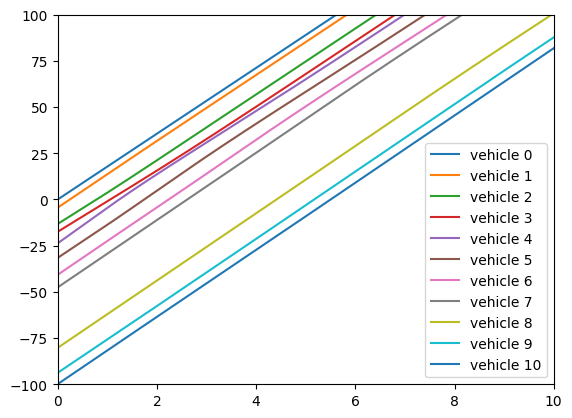

In [257]:
for i in range(len(vehicle_list)):
    plt.plot(vehicle_list[i].history_t, vehicle_list[i].history_x, label=f"vehicle {i}")
plt.legend()
plt.xlim(0, 10)
plt.ylim(-100, 100)
plt.show()